This synthetic dataset is modeled after an existing milling machine and consists of 10 000 data points from a stored as rows with 14 features in columns

UID: unique identifier ranging from 1 to 10000
product

 ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number

type: just the product type L, M or H from column 2

air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K

process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise

torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.

tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.
The machine failure consists of five independent failure modes

tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).

heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.

power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.

overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.

random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.
If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

 This dataset is part of the following publication, please cite when using this dataset: S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.

## SECTION 1 : Import Libraries

In [80]:
import pandas as pd  # Importing pandas for data manipulation and analysis
import numpy as np  # Importing numpy for numerical operations
import matplotlib.pyplot as plt  # Importing matplotlib for data visualization
import seaborn as sns  # Importing seaborn for advanced visualizations
from sklearn.model_selection import train_test_split  # Splitting dataset into training and testing sets
from sklearn.ensemble import RandomForestClassifier  # Random Forest for classification
from sklearn.svm import SVC  # Support Vector Classifier for classification
from sklearn.linear_model import LogisticRegression  # Logistic Regression for binary classification
from sklearn.neural_network import MLPClassifier  # Neural Network for classification tasks
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # Standardizing features
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, matthews_corrcoef, recall_score, precision_score, f1_score  # Evaluation metrics
from sklearn.model_selection import cross_val_score  # For cross-validation
from imblearn.over_sampling import SMOTE  # Handling imbalanced datasets

In [81]:
# Load Dataset
df = pd.read_csv('ai4i2020.csv')  # Loading the dataset into a pandas DataFrame

In [82]:
df.shape

(10000, 14)

In [83]:
df.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [85]:
# Check for missing values
df.isnull().sum() # Checking for missing data in the dataset

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [86]:
# Drop unnecessary columns
columns_to_drop = ['UDI', 'Product ID', 'Type']  # Columns that are irrelevant for prediction
df = df.drop(columns=columns_to_drop, axis=1)  # Dropping the unnecessary columns

In [93]:
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


Air temperature [K], Process temperature [K], Rotational speed [rpm, Torque [Nm] show low to moderate variability and Tool wear [min] show high variability with (std=63.65) and wide range from (0-253min)

In [88]:
print(df.isna().sum())

Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


In [94]:
# Check for duplicates
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


The dataset has no null values and no duplicates 

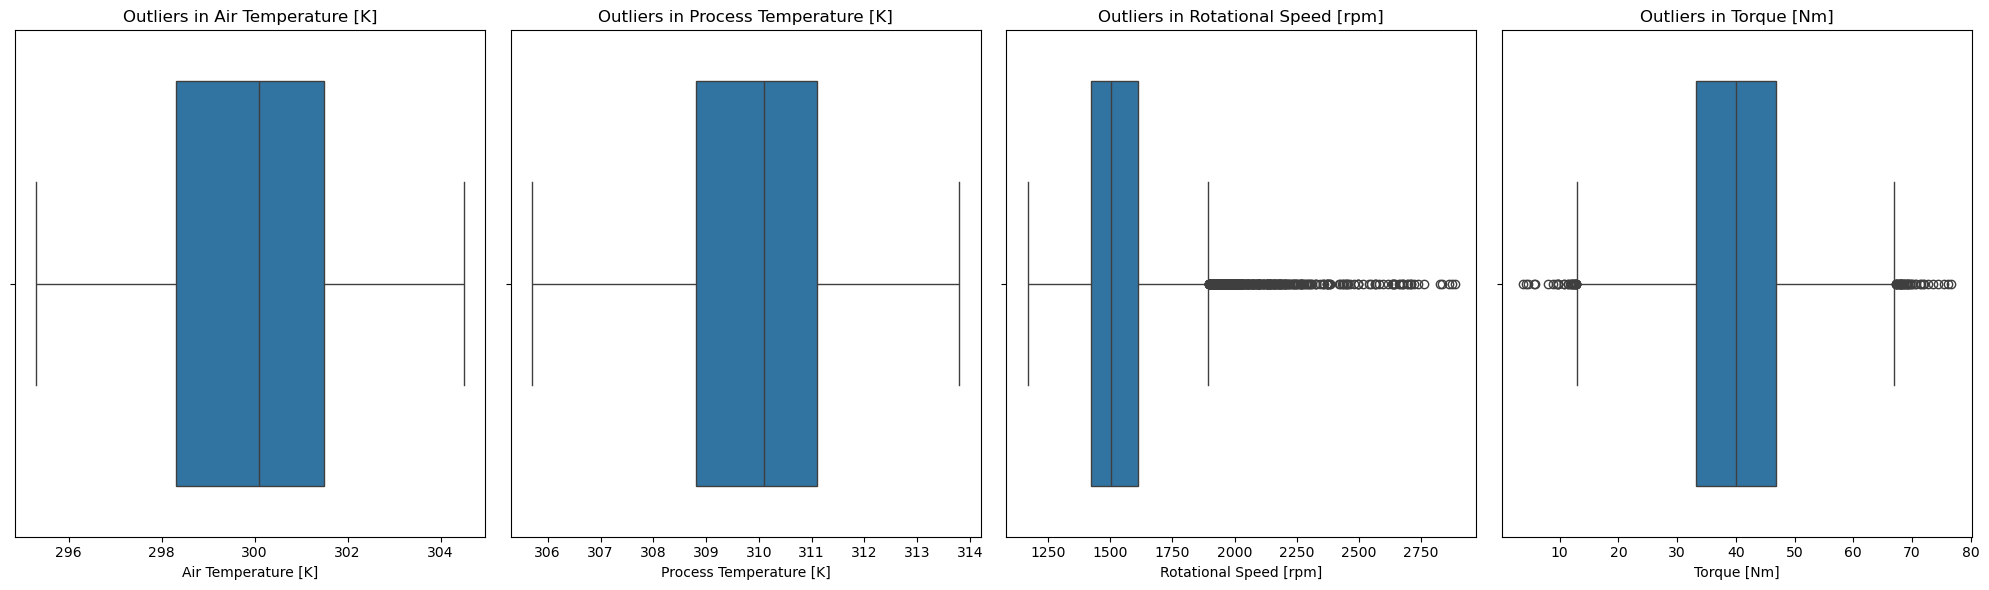

In [90]:
# Create a figure and subplots
plt.figure(figsize=(20, 6))  # Adjust figure size

# Boxplot for 'Air temperature [K]'
plt.subplot(1, 4, 1)
sns.boxplot(x=df['Air temperature [K]'])
plt.title('Outliers in Air Temperature [K]')
plt.xlabel('Air Temperature [K]')

# Boxplot for 'Process temperature [K]'
plt.subplot(1, 4, 2)
sns.boxplot(x=df['Process temperature [K]'])
plt.title('Outliers in Process Temperature [K]')
plt.xlabel('Process Temperature [K]')

# Boxplot for 'Rotational speed [rpm]'
plt.subplot(1, 4, 3)
sns.boxplot(x=df['Rotational speed [rpm]'])
plt.title('Outliers in Rotational Speed [rpm]')
plt.xlabel('Rotational Speed [rpm]')

# Boxplot for 'Torque [Nm]'
plt.subplot(1, 4, 4)
sns.boxplot(x=df['Torque [Nm]'])
plt.title('Outliers in Torque [Nm]')
plt.xlabel('Torque [Nm]')

# Adjust layout
plt.tight_layout()
plt.show()


In [98]:
# Function to detect outliers using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# List of columns to check for outliers
columns_to_check = ["Rotational speed [rpm]", "Torque [Nm]"]

# Loop through each column and print rows with outliers
for col in columns_to_check:
    outliers = detect_outliers(df, col)
    print(f"Outliers in {col} (Total: {outliers.shape[0]}):")
    print(outliers)



Outliers in Rotational speed [rpm] (Total: 418):
      Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
14                  298.6                    309.2                    2035   
50                  298.9                    309.1                    2861   
70                  298.9                    309.0                    1924   
101                 298.8                    308.8                    1991   
155                 298.4                    308.2                    1987   
...                   ...                      ...                     ...   
9865                298.9                    309.8                    2450   
9871                298.9                    309.8                    1947   
9886                298.8                    309.6                    1903   
9926                298.5                    308.6                    1897   
9939                298.3                    308.1                    2636   

      Torque [

In most of the cases of outliers in Torque there has been a machine failure this suggests the outliers need not be handled.

In [15]:
# Count total machine failures
total_failures = df['Machine failure'].sum()

# Print the total number of machine failures
print(f"Total Machine Failure Instances: {total_failures}")

Total Machine Failure Instances: 339


In [16]:
# Filter rows where Machine failure occurred
failure_df = df[df['Machine failure'] == 1]
failure_df

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
50,298.9,309.1,2861,4.6,143,1,0,0,1,0,0
69,298.9,309.0,1410,65.7,191,1,0,0,1,1,0
77,298.8,308.9,1455,41.3,208,1,1,0,0,0,0
160,298.4,308.2,1282,60.7,216,1,0,0,0,1,0
161,298.3,308.1,1412,52.3,218,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
9758,298.6,309.8,2271,16.2,218,1,1,0,0,0,0
9764,298.5,309.5,1294,66.7,12,1,0,0,1,0,0
9822,298.5,309.4,1360,60.9,187,1,0,0,0,1,0
9830,298.3,309.3,1337,56.1,206,1,0,0,0,1,0


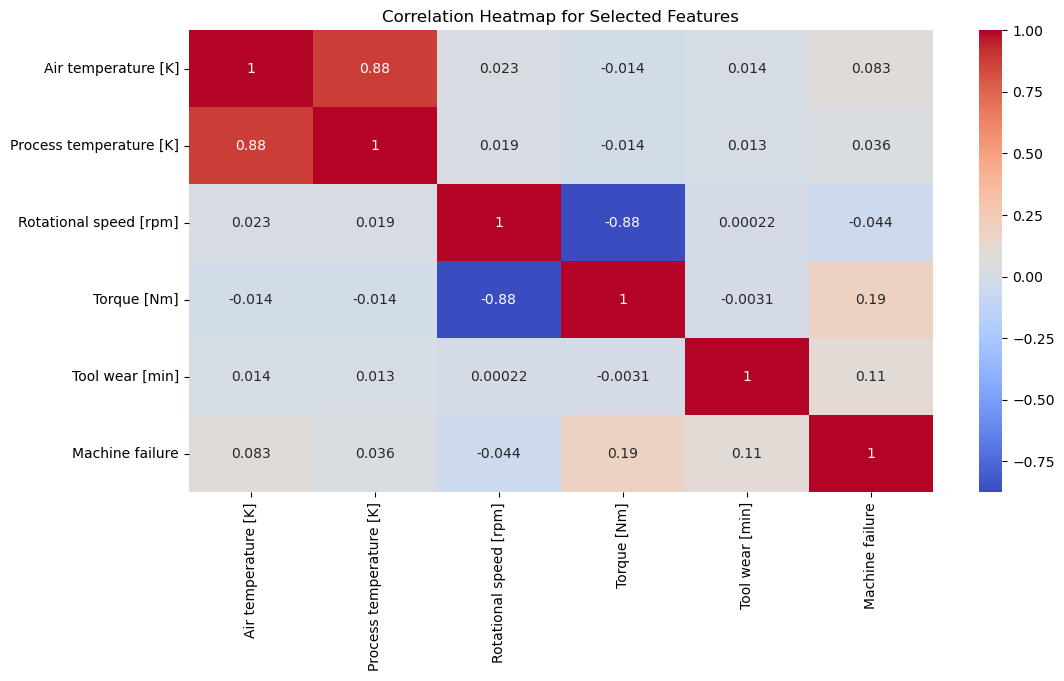

In [18]:
# Heatmap for selected columns
selected_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure']
plt.figure(figsize=(12, 6))  # Setting figure size for heatmap
sns.heatmap(df[selected_columns].corr(), annot=True, cmap='coolwarm')  # Heatmap for correlation between selected features
plt.title('Correlation Heatmap for Selected Features')  # Adding a title to the heatmap
plt.show()  # Displaying the heatmap

Air Temperature [K] and Process Temperature [K]
Correlation (0.88): These attributes are highly correlated, so one of them could potentially be dropped to reduce redundancy in machine learning models.

In [19]:
X_overall = df.drop(['Process temperature [K]'], axis=1) # dropping Process temperarture

In [20]:
X_overall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Air temperature [K]     10000 non-null  float64
 1   Rotational speed [rpm]  10000 non-null  int64  
 2   Torque [Nm]             10000 non-null  float64
 3   Tool wear [min]         10000 non-null  int64  
 4   Machine failure         10000 non-null  int64  
 5   TWF                     10000 non-null  int64  
 6   HDF                     10000 non-null  int64  
 7   PWF                     10000 non-null  int64  
 8   OSF                     10000 non-null  int64  
 9   RNF                     10000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 781.4 KB


In [21]:
# Sanitize feature names
X = X_overall.columns.str.replace(r"[\\[\\]<>]", "", regex=True)

In [22]:
# Feature Selection and Preprocessing
X = df.drop(['Machine failure'], axis=1)  # Features for prediction
y = df['Machine failure']  # Target variable

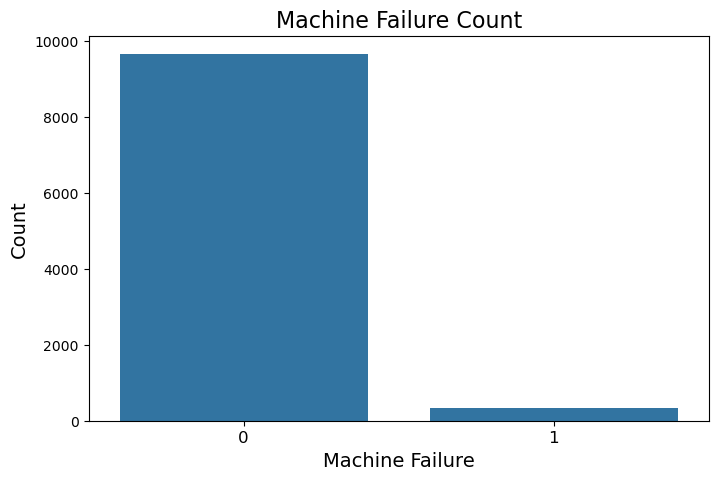

In [23]:
# Plot machine failure counts
plt.figure(figsize=(8, 5))
sns.countplot(x='Machine failure', data=df)
plt.title('Machine Failure Count', fontsize=16)
plt.xlabel('Machine Failure', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['0', '1'], fontsize=12)
plt.show()

Class Imbalance Problem
Imbalance Ratio:
The number of instances for the majority class (no failures) is disproportionately higher than the minority class (failures).
Machine learning models trained on such data tend to bias predictions towards the majority class, leading to poor recall for the minority class (failures).

In [24]:
from imblearn.over_sampling import SMOTE
# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)  # Initializing SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)  # Oversampling the minority class

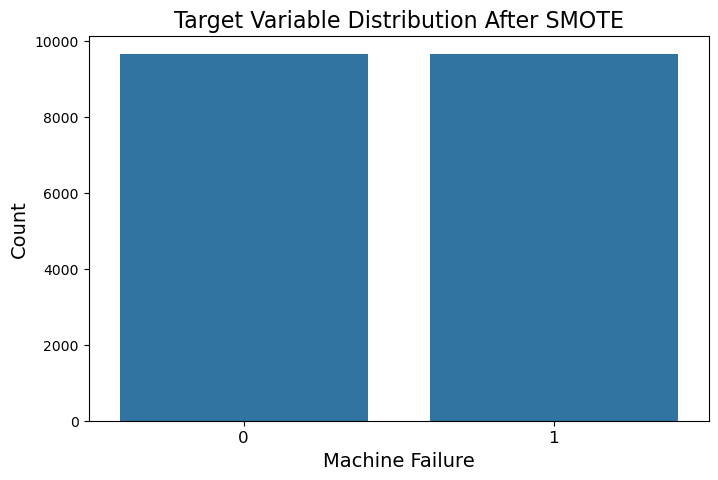

In [25]:
plt.figure(figsize=(8, 5))
sns.countplot(x=y_resampled,)
plt.title('Target Variable Distribution After SMOTE', fontsize=16)
plt.xlabel('Machine Failure', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['0', '1'], fontsize=12)
plt.show()

Class Balance Achieved
The target variable (Machine Failure) now has an equal number of instances for both classes (0 and 1).
This resolves the severe class imbalance observed in the original dataset, ensuring the model can focus equally on predicting both failure and non-failure cases.


In [26]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)  # Splitting data

In [27]:
# Normalize the features
scaler = StandardScaler()  # Initializing StandardScaler
X_scaled = scaler.fit_transform(X)  # Standardizing the features

In [28]:
# Convert scaled data back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [29]:
# Display the scaled data
X_scaled_df.head(5)  # View the first 5 rows

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984,-0.06798,-0.10786,-0.097934,-0.099484,-0.04363
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,-0.06798,-0.10786,-0.097934,-0.099484,-0.04363
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,-0.06798,-0.10786,-0.097934,-0.099484,-0.04363
3,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009,-0.06798,-0.10786,-0.097934,-0.099484,-0.04363
4,-0.902393,-0.879959,-0.729472,0.001313,-1.554588,-0.06798,-0.10786,-0.097934,-0.099484,-0.04363


In [35]:
# Models to Test
models = {
    'Support Vector Machine': SVC(random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Neural Network': MLPClassifier(random_state=42, max_iter=500),
}

In [42]:
import time
# Evaluate Each Model with Metrics
performance_data = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Training the model
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    
    # Predicting on test set
    start_predict = time.time()
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    end_predict = time.time()

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{name} - Confusion Matrix:\n{cm}")

    # Append metrics to performance_data
    performance_data.append({
        "Model": name,
        "Accuracy": round(accuracy * 100, 2),
        "Recall": round(recall * 100, 2),
        "Precision": round(precision * 100, 2),
        "F1-Score": round(f1 * 100, 2),
        "MCC Score": round(mcc * 100, 2),
        "Time to Train (s)": round(end_train - start_train, 2),
        "Time to Predict (s)": round(end_predict - start_predict, 2),
        "Total Time (s)": round((end_train - start_train) + (end_predict - start_predict), 2)
    })


Training Support Vector Machine...

Support Vector Machine - Confusion Matrix:
[[1563  371]
 [ 262 1669]]

Training Logistic Regression...

Logistic Regression - Confusion Matrix:
[[1848   86]
 [ 228 1703]]

Training Neural Network...

Neural Network - Confusion Matrix:
[[1316  618]
 [  29 1902]]


In [99]:
# Iterate through each model to calculate training and testing accuracy
accuracy_data = []

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    
    # Training Accuracy
    y_train_pred = model.predict(X_train)
    training_accuracy = accuracy_score(y_train, y_train_pred)
    
    # Testing Accuracy
    y_test_pred = model.predict(X_test)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Append accuracy results for this model
    accuracy_data.append({
        "Model": name,
        "Training Accuracy": round(training_accuracy * 100, 2),
        "Testing Accuracy": round(testing_accuracy * 100, 2)
    })
    
    print(f"{name} - Training Accuracy: {training_accuracy:.4f}")
    print(f"{name} - Testing Accuracy: {testing_accuracy:.4f}")

# Create a DataFrame for easier comparison
accuracy_df = pd.DataFrame(accuracy_data)

# Display the results in a tabular format
print("\nModel Training and Testing Accuracy:")
accuracy_df



Evaluating Support Vector Machine...
Support Vector Machine - Training Accuracy: 0.8282
Support Vector Machine - Testing Accuracy: 0.8362

Evaluating Logistic Regression...
Logistic Regression - Training Accuracy: 0.9214
Logistic Regression - Testing Accuracy: 0.9188

Evaluating Neural Network...
Neural Network - Training Accuracy: 0.8262
Neural Network - Testing Accuracy: 0.8326

Model Training and Testing Accuracy:


,Model,Training Accuracy,Testing Accuracy
0,Support Vector Machine,82.82,83.62
1,Logistic Regression,92.14,91.88
2,Neural Network,82.62,83.26


Logistic Regression performs the best, with high and consistent training (92.14%) and testing accuracy (91.88%), indicating effective generalization and minimal overfitting. Support Vector Machine (83.62%) and Neural Network (83.26%) show similar but lower performance, likely due to underfitting or insufficient tuning.
Logistic Regression's efficiency and strong predictive accuracy make it the optimal choice for this dataset. Further hyperparameter tuning could improve SVM and Neural Network performance if required.

In [45]:
# Convert the performance data into a DataFrame
performance_df = pd.DataFrame(performance_data)

# Print the DataFrame to display the results in a tabular format
print("\nModel Performance Metrics:")
performance_df


Model Performance Metrics:


,Model,Accuracy,Recall,Precision,F1-Score,MCC Score,Time to Train (s),Time to Predict (s),Total Time (s)
0,Support Vector Machine,83.62,86.43,81.81,84.06,67.35,82.61,9.47,92.07
1,Logistic Regression,91.88,88.19,95.19,91.56,83.98,0.23,0.01,0.24
2,Neural Network,83.26,98.50,75.48,85.46,69.85,3.71,0.01,3.72


### Recommendation
Best Overall Model: Logistic Regression

Best trade-off between accuracy, precision, recall, F1-Score, and MCC.
Extremely fast to train and predict, making it highly efficient.

If High Recall Is Critical: Neural Network
Suitable when detecting all failures (high recall) is more important than avoiding false positives.

SVM
Offers balanced performance but is not as efficient or accurate as Logistic Regression, making it less competitive in this case.

### Business implication

Application:
This machine learning model can identify failure patterns based on real-time machine parameters.
Deploying these models in production to monitor machinery in real-time, reduces unplanned downtime and maintenance costs.

Benefits:
Improved machine reliability.
Increased operational efficiency by scheduling maintenance proactively.
Reduced financial losses due to sudden equipment failures.